In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [76]:
# 랜덤 시드를 고정하여 매 실행마다 같은 결과가 나오도록 설정
torch.manual_seed(777)

# 사용할 이미지의 크기 지정 (가로 128 x 세로 128)
IMAGE_SIZE = 128

# GPU 사용 가능 여부 확인 후, 가능하면 'cuda' 사용, 그렇지 않으면 'cpu' 사용
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 만약 GPU를 사용할 수 있다면, CUDA 관련 랜덤 시드도 고정 (재현성 확보)
if device == 'cuda':
    torch.cuda.manual_seed(777)

# 현재 사용 중인 연산 장치(GPU 또는 CPU) 출력
print(device)

cpu


In [77]:
# 이미지 폴더에서 데이터를 불러오고, 지정된 전처리를 적용한 후 Dataset 객체로 만듦
original_datasets = ImageFolder(
    root='data/flower_photos',       # 이미지가 저장된 최상위 폴더 경로
    transform=transforms.Compose([   # 이미지에 순차적으로 적용할 전처리(transform) 목록
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # 모든 이미지를 지정된 크기(128x128)로 리사이즈
        transforms.ToTensor()        # 이미지를 PyTorch 텐서로 변환하고 픽셀 값을 [0, 1] 범위로 정규화
    ])
)

# 데이터셋 객체의 정보 출력 (총 이미지 개수, 클래스 수, 클래스 이름 등)
print(original_datasets)

Dataset ImageFolder
    Number of datapoints: 2313
    Root location: data/flower_photos
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [78]:
# DataLoader를 사용해 original_datasets를 배치 단위로 불러올 수 있도록 설정
original_loader = DataLoader(
    original_datasets,    # 앞서 만든 이미지 데이터셋 객체
    batch_size=2313,      # 한 번에 불러올 이미지 수 (전체 데이터를 한 배치로 불러옴)
    shuffle=True,         # 매 epoch마다 데이터를 섞어서 모델이 순서에 의존하지 않도록 함
    drop_last=False,      # 마지막 배치가 batch_size보다 작아도 버리지 않고 그대로 사용
    num_workers=1         # 데이터를 로딩할 때 사용할 서브 프로세스 개수 (CPU 쓰레드 1개 사용)
)

In [79]:
# DataLoader(original_loader)에서 배치 단위로 이미지(X)와 레이블(Y)를 꺼내옴
for X, Y in original_loader:
    # 현재 배치의 이미지 텐서 크기 출력 → (배치크기, 채널수, 높이, 너비)
    print(X.size())
    
    # 현재 배치의 라벨(클래스 인덱스) 텐서 크기 출력 → (배치크기,)
    print(Y.size())
    
    # 실제 라벨 값 출력 (0부터 시작하는 정수 인덱스, 폴더 순서대로 자동 부여됨)
    print(Y)

# 참고: ImageFolder는 하위 폴더명을 클래스 이름으로 간주하고,
#      해당 순서대로 0, 1, 2, ... 식으로 정수 레이블을 자동 생성함.

torch.Size([2313, 3, 128, 128])
torch.Size([2313])
tensor([3, 0, 4,  ..., 4, 3, 2])


In [ ]:
# DataLoader(original_loader)에서 하나의 배치를 추출
# iter()로 반복자를 만들고 next()로 첫 번째 배치(imgs, labels)를 가져옴
imgs, labels = next(iter(original_loader))

# 추출된 이미지 배치의 크기 출력 → (배치크기, 채널 수, 높이, 너비)
print(imgs.size())

# 추출된 라벨 배치의 크기 출력 → (배치크기,)
print(labels.size())

torch.Size([2313, 3, 128, 128]) torch.Size([2313])


In [ ]:
# 현재 배치에 포함된 이미지들의 정답 레이블(클래스 인덱스)을 출력
# ImageFolder는 폴더명 순서대로 정수 인덱스를 부여하기 때문에,
# 출력값은 예: tensor([0, 1, 3, 2, 4, ..., 1]) 이런 식의 형태로 나옴
print(labels)

tensor([1, 3, 3,  ..., 3, 0, 2])


In [ ]:
# Mac 또는 Windows 환경에서 라이브러리 충돌 방지를 위한 설정
# (특히 matplotlib와 Intel MKL 라이브러리 충돌 방지 목적)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# 전체 이미지 출력을 위한 Figure 크기 설정 (가로 8인치, 세로 10인치)
plt.figure(figsize=(8, 10))

# 이미지와 라벨을 시각화하는 함수 정의
def plot(x, y):
    # x: 이미지 텐서들, y: 레이블 텐서들
    for i in range(len(x)):
        # 5행 5열의 서브플롯 구성, 현재 위치는 i+1번째 (1부터 시작)
        plt.subplot(5, 5, i + 1)

        # 해당 이미지의 라벨 값을 제목으로 설정 (Tensor → 정수 변환)
        plt.title(y[i].item())

        # 이미지 텐서의 차원 순서를 (채널, 높이, 너비) → (높이, 너비, 채널)로 변경 (시각화용)
        plt.imshow(x[i].permute(1, 2, 0))

        # x축, y축 눈금 제거
        plt.axis('off')

    # 전체 이미지 출력
    plt.show()

<Figure size 800x1000 with 0 Axes>

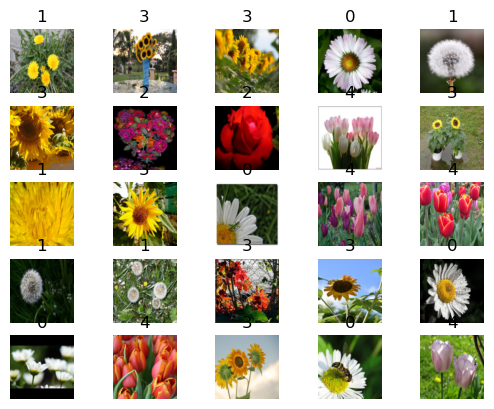

In [ ]:
# 앞서 정의한 plot() 함수를 호출하여
# 첫 번째 배치에서 앞의 25개 이미지와 라벨을 시각화함
plot(imgs[:25], labels[:25])

In [ ]:
# imgs와 labels를 X1, Y1이라는 이름의 변수로 저장
# 이후 데이터 증강이나 합치기 등에 사용할 원본 데이터셋의 복사본 역할
X1 = imgs
Y1 = labels

# 이미지 텐서와 라벨 텐서의 크기 출력
# 예: torch.Size([2313, 3, 128, 128]), torch.Size([2313])
print(X1.size(), Y1.size())

torch.Size([2313, 3, 128, 128]) torch.Size([2313])


In [25]:
# ─────────────────────────────────────────────
# [1] 이미지 전처리 파이프라인 정의
# ─────────────────────────────────────────────

img_transform = transforms.Compose([
    transforms.Resize((256, 256)),                 # 모든 이미지를 256x256 크기로 리사이즈
    transforms.CenterCrop((IMAGE_SIZE, IMAGE_SIZE)),  # 중앙을 기준으로 IMAGE_SIZE(128x128)만큼 자르기
    transforms.ToTensor()                          # 이미지를 텐서로 변환 (0~255 → 0~1 범위 정규화됨)
])
# ─────────────────────────────────────────────
# [2] 이미지 폴더에서 데이터셋 로드
# ─────────────────────────────────────────────

transforms_dataset = ImageFolder(
    root='data/flower_photos',  # 하위 폴더명(=클래스명)을 라벨로 인식
    transform=img_transform     # 위에서 정의한 전처리 파이프라인 적용
)
# ─────────────────────────────────────────────
# [3] DataLoader로 배치 단위 불러오기
# ─────────────────────────────────────────────

transforms_loader = DataLoader(
    transforms_dataset,  # 앞에서 정의한 ImageFolder 객체
    batch_size=1000,     # 한 번에 1000장씩 가져옴
    shuffle=True,        # 매 epoch마다 데이터 섞기
    num_workers=1        # 데이터를 병렬로 로딩할 워커 수
)

In [ ]:
# ─────────────────────────────────────────────
# [4] 배치 하나 추출하여 이미지와 라벨 확인
# ─────────────────────────────────────────────

# transforms_loader에서 배치 하나를 추출 (iter → next를 통해 한 번에 불러오기)
# transform_img: 이미지 텐서들 (예: [1000, 3, 128, 128])
# transform_label: 각 이미지에 해당하는 정답 레이블 (예: [1000])
transform_img, transform_label = next(iter(transforms_loader))

# 이미지와 라벨 텐서의 shape 출력 (배치 크기, 채널 수, 높이, 너비 / 배치 크기)
print(transform_img.shape, transform_label.shape)

torch.Size([1000, 3, 128, 128]) torch.Size([1000])


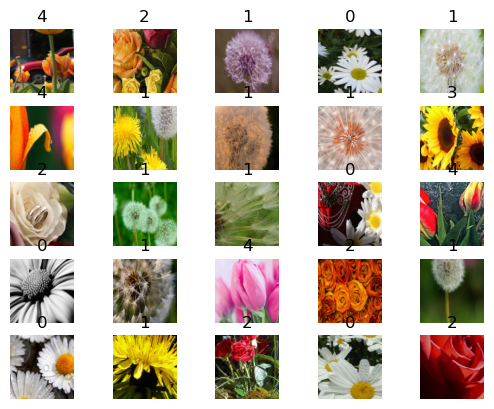

In [ ]:
# 변환된 이미지들 중 앞의 25장을 시각화하여 확인
# → 이미지 25장과 각각의 레이블(클래스 인덱스)을 5행 5열로 출력
plot(transform_img[:25], transform_label[:25])

In [ ]:
# 기존 원본 이미지(X1)와 새로 전처리된 이미지(transform_img)를 합쳐 하나의 텐서로 만듦
# dim=0 → 배치 차원(행 방향)으로 이어붙이기 (즉, 이미지 수 증가)
X2 = torch.cat([X1, transform_img], dim=0)

# 동일하게 기존 레이블(Y1)과 새로 로드된 레이블(transform_label)도 하나로 결합
Y2 = torch.cat([Y1, transform_label], dim=0)

# 결합된 전체 이미지 텐서와 라벨 텐서의 크기 출력
# 예: X2: [2313+1000, 3, 128, 128], Y2: [3313]
print(X2.size(), Y2.size())

torch.Size([3313, 3, 128, 128]) torch.Size([3313])


In [ ]:
# 이미지 전처리(transform)를 인자로 받아,
# 해당 전처리를 적용한 데이터셋을 로드하고,
# 그 중 한 배치를 반환하는 함수

def create_loader(transforms):
    # [1] 이미지 폴더에서 전처리 적용된 데이터셋 로드
    transforms_dataset = ImageFolder(
        root='data/flower_photos',  # 클래스별 폴더가 있는 루트 경로
        transform=transforms        # 외부에서 전달받은 전처리 파이프라인 적용
    )

    # [2] DataLoader로 데이터를 배치 단위로 불러오기
    transforms_loader = DataLoader(
        transforms_dataset,
        batch_size=1000,   # 한 번에 1000장씩 로드
        shuffle=True,      # 배치마다 무작위 셔플
        num_workers=1      # 병렬 로딩 프로세스 수
    )

    # [3] 로드된 배치 중 첫 번째 배치를 추출
    transform_img, transform_label = next(iter(transforms_loader))

    # [4] 변환된 이미지 텐서와 레이블을 반환
    return transform_img, transform_label

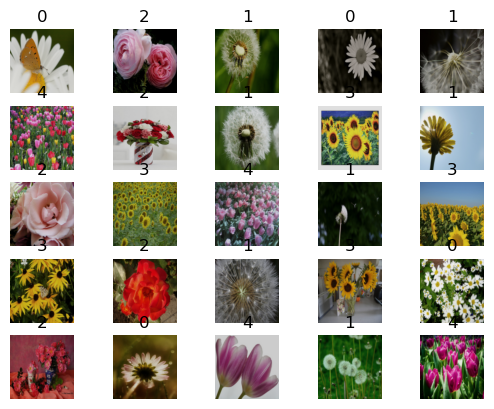

In [ ]:
# ─────────────────────────────────────────────
# [색상 증강을 위한 전처리 파이프라인 정의]
# ─────────────────────────────────────────────
img_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # 모든 이미지를 지정된 크기(128x128)로 리사이즈

    # ColorJitter: 색상 정보 왜곡 (밝기, 채도 조정 등)
    transforms.ColorJitter(
        brightness=(0.8, 0.95),   # 밝기: 원본 대비 80% ~ 95%로 조절
        contrast=(1, 1),          # 대비는 그대로 유지
        saturation=(0.8, 0.95),   # 채도: 원본 대비 80% ~ 95%로 조절
        # hue=(-0.2, 0.2)         # 색조 변화는 비활성화 (주석 처리됨)
    ),

    transforms.ToTensor()  # 이미지 → Tensor로 변환 (0~1 정규화 포함)
])

# ─────────────────────────────────────────────
# [정의된 색상 증강 파이프라인을 이용해 데이터 1배치 생성]
# ─────────────────────────────────────────────
color_tf_image, color_tf_label = create_loader(img_transform)

# ─────────────────────────────────────────────
# [변환된 이미지 중 앞 25장을 시각화하여 확인]
# ─────────────────────────────────────────────
plot(color_tf_image[:25], color_tf_label[:25])

In [ ]:
# 기존 데이터셋 X2, Y2에 색상 증강된 이미지(color_tf_image)와 레이블(color_tf_label)을 추가로 합침
# → 전체 학습 데이터셋 확장 (데이터 증강 효과)

X3 = torch.cat([X2, color_tf_image], dim=0)  # 이미지 텐서들을 첫 번째 차원(=배치 차원)을 기준으로 이어붙임
Y3 = torch.cat([Y2, color_tf_label], dim=0)  # 레이블도 같은 방식으로 결합

# 새로운 전체 데이터셋의 크기 출력
print(X3.size(), Y3.size())  # 예: torch.Size([4626, 3, 128, 128]) torch.Size([4626])

torch.Size([4313, 3, 128, 128]) torch.Size([4313])


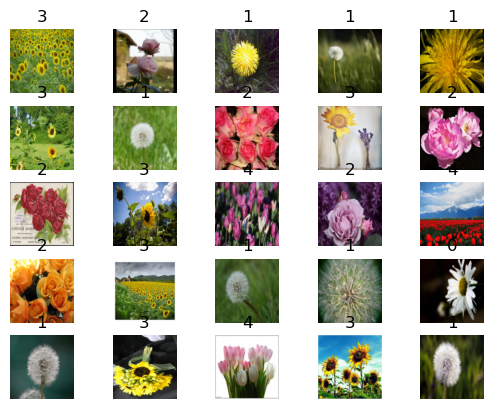

torch.Size([5313, 3, 128, 128]) torch.Size([5313])


In [ ]:
# [좌우 반전 기반 데이터 증강 파이프라인 정의]
image_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),      # 모든 이미지를 동일한 크기(128x128)로 리사이즈
    transforms.RandomHorizontalFlip(p=0.8),           # 80% 확률로 이미지를 좌우 반전 (데이터 다양성 ↑)
    transforms.ToTensor()                             # 이미지 데이터를 텐서로 변환 (0~1 정규화 포함)
])

# 위에서 정의한 transform을 적용한 이미지·레이블 한 배치를 생성
flip_tf_images, flip_tf_labels = create_loader(image_transform)

# 증강된 이미지 25장을 시각화하여 반전이 잘 적용되었는지 확인
plot(flip_tf_images[:25], flip_tf_labels[:25])

# 기존 데이터셋(X3, Y3)에 좌우반전된 이미지와 레이블을 추가
X4 = torch.cat([X3, flip_tf_images], dim=0)  # 이미지 텐서 합치기
Y4 = torch.cat([Y3, flip_tf_labels], dim=0)  # 레이블 텐서 합치기

# 현재까지 누적된 전체 데이터셋 크기 확인
print(X4.size(), Y4.size())  # 예: torch.Size([6939, 3, 128, 128]) torch.Size([6939])

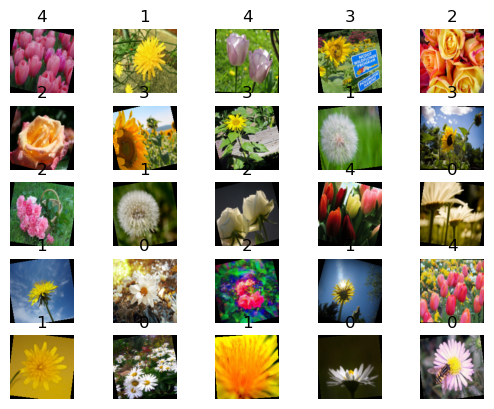

torch.Size([6313, 3, 128, 128]) torch.Size([6313])


In [ ]:
# [랜덤 회전 기반 데이터 증강 파이프라인 정의]
image_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # 모든 이미지를 128x128 크기로 통일
    transforms.RandomRotation(                   # 이미지를 -15도 ~ +15도 사이로 랜덤하게 회전
        degrees=(-15, 15),
        interpolation=transforms.InterpolationMode.BILINEAR,  # 회전 시 보간 방법: Bilinear(선형 보간)
        fill=0  # 회전 후 빈 공간은 검은색(0)으로 채움
    ),
    transforms.ToTensor()  # 텐서로 변환 (정규화 포함)
])

# 위에서 정의한 transform을 적용한 이미지·레이블 배치 가져오기
rot_tf_images, rot_tf_labels = create_loader(image_transform)

# 회전된 이미지 일부를 시각화 (잘 회전되었는지 확인)
plot(rot_tf_images[:25], rot_tf_labels[:25])

# 누적된 데이터셋에 회전된 이미지와 라벨 추가
X5 = torch.cat([X4, rot_tf_images], dim=0)  # 이미지 추가
Y5 = torch.cat([Y4, rot_tf_labels], dim=0)  # 라벨 추가

# 누적된 전체 데이터셋 크기 확인
print(X5.size(), Y5.size())  # 예: torch.Size([9252, 3, 128, 128]) torch.Size([9252])

In [ ]:
# ─────────────────────────────────────────────
# [각 클래스(0~4)의 샘플 개수 계산]
# ─────────────────────────────────────────────

cnt0 = (Y5 == 0).sum()  # 라벨 값이 0인 샘플의 수
cnt1 = (Y5 == 1).sum()  # 라벨 값이 1인 샘플의 수
cnt2 = (Y5 == 2).sum()  # 라벨 값이 2인 샘플의 수
cnt3 = (Y5 == 3).sum()  # 라벨 값이 3인 샘플의 수
cnt4 = (Y5 == 4).sum()  # 라벨 값이 4인 샘플의 수

# 각 클래스별 샘플 개수 출력 (정수형으로 변환 후 출력)
print(cnt0.item(), cnt1.item(), cnt2.item(), cnt3.item(), cnt4.item())

1118 1560 1164 1410 1061


In [ ]:
# ─────────────────────────────────────────────
# [학습/테스트 데이터 분할 비율 설정 및 샘플 수 계산]
# ─────────────────────────────────────────────

ratio = [0.8, 0.2]  
# 전체 데이터 중 80%는 학습용(train), 20%는 테스트용(test)으로 사용하겠다는 의미

train_cnt = int(Y5.size(0) * ratio[0])  
# 전체 데이터 개수(Y5.size(0))에서 80%에 해당하는 개수를 정수형으로 계산 → 학습용 데이터 개수

test_cnt = int(Y5.size(0) * ratio[1])   
# 전체 데이터 중 나머지 20% → 테스트용 데이터 개수

print(train_cnt, test_cnt)  
# 계산된 학습용/테스트용 데이터 개수를 출력해서 확인

cnts = [train_cnt, test_cnt]  
# 이후 split 등에 활용하기 위해 리스트로 묶어서 저장

5050 1262


In [ ]:
# ─────────────────────────────────────────────
# [학습/테스트 데이터셋을 무작위로 섞기 위한 인덱스 생성]
# ─────────────────────────────────────────────

indices = torch.randperm(X5.size(0))  
# 0부터 전체 데이터 개수(X5.size(0)) - 1까지의 숫자를 무작위로 섞어서 반환
# 예: [3, 0, 2, 1, 4, ...] ← 데이터를 이 순서대로 재배열할 수 있음

print(indices)  
# 무작위로 생성된 인덱스를 출력해서 확인

tensor([ 709, 2740, 4714,  ..., 4143, 2631, 4200])


In [ ]:
# ─────────────────────────────────────────────
# [무작위로 섞은 인덱스를 기준으로 학습/테스트 데이터 분리]
# ─────────────────────────────────────────────

x = torch.index_select(X5, dim=0, index=indices)
# X5에서 0번 차원(샘플 차원)을 기준으로, indices 순서대로 데이터를 재배열

y = torch.index_select(Y5, dim=0, index=indices)
# Y5도 동일하게 인덱스를 이용해 라벨 순서를 맞춰서 재배열

# 학습용 데이터 분리 (앞쪽 80%)
x_train = x[:cnts[0]]   # cnts[0] == train_cnt
y_train = y[:cnts[0]]

# 테스트용 데이터 분리 (뒤쪽 20%)
x_test = x[cnts[0]:]    # cnts[1] == test_cnt
y_test = y[cnts[0]:]

# 학습/테스트 데이터 크기 출력
print(x_train.size(), y_train.size())
print(x_test.size(), y_test.size())

torch.Size([5050, 3, 128, 128]) torch.Size([5050])
torch.Size([1263, 3, 128, 128]) torch.Size([1263])


In [ ]:
# 학습용 입력(x_train)과 정답(y_train)을 하나의 Dataset으로 묶음
train_dataset = TensorDataset(x_train, y_train)

# 테스트용 입력(x_test)과 정답(y_test)을 하나의 Dataset으로 묶음
test_dataset = TensorDataset(x_test, y_test)

# 두 데이터셋의 정보 출력 (샘플 개수와 샘플의 형태 확인용)
print(train_dataset)
print(test_dataset)

In [ ]:
# ─────────────────────────────────────────────
# [학습용 DataLoader 생성]
# ─────────────────────────────────────────────

train_loader = DataLoader(
    train_dataset,     # 학습용 TensorDataset
    batch_size=100,    # 한 번에 불러올 데이터 수 (배치 크기)
    shuffle=True,      # 매 epoch마다 데이터를 섞어 학습
    drop_last=False    # 마지막 배치가 batch_size보다 작아도 포함시킴
)

# ─────────────────────────────────────────────
# [테스트용 DataLoader 생성]
# ─────────────────────────────────────────────

test_loader = DataLoader(
    test_dataset,      # 테스트용 TensorDataset
    batch_size=100,    # 한 번에 불러올 데이터 수
    shuffle=True,      # 테스트셋도 무작위로 섞어서 평가
    drop_last=False    # 마지막 배치도 포함 (작더라도)
)

In [51]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # ─────────────────────────────────────────────
        # [입력: RGB 이미지 (3채널, 64x64)]로 가정
        # Conv 레이어: 커널 3x3, padding=1 → 크기 유지됨
        # Pooling 레이어: 2x2 max pooling → 크기 절반
        # ─────────────────────────────────────────────

        self.conv1 = nn.Conv2d(3, 8, 3, stride=1, padding=1)     # 입력: (3, 64, 64) → 출력: (8, 64, 64)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=1, padding=1)    # → (16, 32, 32)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)   # → (32, 16, 16)
        self.conv4 = nn.Conv2d(32, 64, 3, stride=1, padding=1)   # → (64, 8, 8)
        self.conv5 = nn.Conv2d(64, 128, 3, stride=1, padding=1)  # → (128, 4, 4)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2 max pooling (크기 절반)

        # 완전 연결층 (FC)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Flatten된 입력 2048 → 128
        self.fc2 = nn.Linear(128, 64)          # 128 → 64
        self.fc3 = nn.Linear(64, 5)            # 64 → 5 (5개 클래스 분류)

    def forward(self, x):
        # ───── Conv → ReLU → Pooling 반복 구조 ─────

        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.pool(x)  # (8, 64, 64) → (8, 32, 32)

        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.pool(x)  # (16, 32, 32) → (16, 16, 16)

        x = self.conv3(x)
        x = nn.ReLU()(x)
        x = self.pool(x)  # (32, 16, 16) → (32, 8, 8)

        x = self.conv4(x)
        x = nn.ReLU()(x)
        x = self.pool(x)  # (64, 8, 8) → (64, 4, 4)

        x = self.conv5(x)
        x = nn.ReLU()(x)
        x = self.pool(x)  # (128, 4, 4) → (128, 2, 2)

        x = x.view(x.size(0), -1)  # Flatten: (batch_size, num_features)
        
        # ───── FC 레이어들 ─────
        x = self.fc1(x)  # (512 → 128)
        x = self.fc2(x)  # (128 → 64)
        x = self.fc3(x)  # (64 → 5)

        # softmax는 CrossEntropyLoss에서 자동 적용되므로 생략
        return x

In [52]:
# 모델 객체를 생성하고 GPU/CPU 중 사용 가능한 장치로 이동
model = CNN().to(device)
print(model)  # 모델 구조 출력

# 옵티마이저: Adam 사용, 학습률은 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 손실 함수: 다중 클래스 분류용 CrossEntropyLoss
crit = nn.CrossEntropyLoss()



CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
)


In [53]:
# ─────────────────────────────────────────────
# 모델 학습 함수 정의
# ─────────────────────────────────────────────
def train(model, train_loader, optimizer):
    model.train()  # 모델을 학습 모드로 설정 (Dropout, BatchNorm 등 활성화)

    # train_loader로부터 배치 단위로 이미지와 레이블을 가져옴
    for batch_index, (img, label) in enumerate(train_loader):
        # 이미지와 라벨을 GPU/CPU 장치로 전송
        img = img.to(device)
        label = label.to(device)

        # 옵티마이저의 기울기 초기화 (이전 값 누적 방지)
        optimizer.zero_grad()

        # 모델 예측값 계산 (forward)
        y_hat = model(img)

        # 손실 계산
        loss = crit(y_hat, label)

        # 역전파로 기울기 계산
        loss.backward()

        # 파라미터 업데이트
        optimizer.step()

        # 10개 배치마다 현재 손실 출력
        if batch_index % 10 == 0:
            print(f'train epoch : {epoch}, train Loss : {loss.item()}')

In [54]:
def evaluate(model, test_loader):
    model.eval()  # 모델을 평가 모드로 설정 (Dropout, BatchNorm 등이 비활성화됨)
    test_loss = 0  # 총 손실 초기화
    correct = 0    # 정답 맞힌 개수 초기화

    # 평가 시에는 gradient 계산 불필요 → 연산 속도/메모리 절약
    with torch.no_grad():
        for img, label in test_loader:
            # 입력 이미지와 라벨을 GPU 혹은 CPU 장치로 전송
            img = img.to(device)
            label = label.to(device)

            # 모델 예측값 계산 (forward)
            y_hat = model(img)

            # 손실 누적: CrossEntropyLoss는 평균값이므로 .item()으로 추출
            test_loss += crit(y_hat, label).item()

            # 예측 결과: 가장 높은 확률을 가진 클래스 선택
            pred = y_hat.argmax(dim=1)  # dim=1: 클래스 차원에서 argmax

            # 정답 개수 누적 (예측 == 실제 라벨)
            correct += (pred == label).sum()

    # 평균 손실 계산: 전체 샘플 개수로 나눔
    test_loss = test_loss / len(test_loader.dataset)

    # 정확도 계산: (맞은 개수 / 전체 개수) × 100 (%)
    test_accuracy = correct / len(test_loader.dataset) * 100

    # 테스트 손실과 정확도 반환
    return test_loss, test_accuracy
        

In [ ]:
epochs = 200              # 총 학습 반복 횟수 설정 (epoch 수)
early_stop = 10           # early stopping을 위한 기준: 최저 손실 이후 몇 epoch 동안 개선 없으면 종료
lowest_loss = np.inf      # 현재까지 관측된 가장 낮은 손실값 (초기값은 무한대로 설정)
lowest_epoch = np.inf     # 가장 낮은 손실값을 기록한 epoch 번호 저장
best_model = None         # 가장 성능 좋았던 모델 파라미터를 저장할 변수 (초기엔 비어있음)
path = 'data/model.pt'    # 최적의 모델을 저장할 파일 경로 (PyTorch 모델 저장 파일)

In [ ]:
for epoch in range(epochs):  
    # 전체 epoch 수만큼 반복하면서 학습 진행

    train(model, train_loader, optimizer)  
    # 1 epoch 동안 학습 데이터를 이용해 모델 학습

    test_loss, test_accuracy = evaluate(model, test_loader)  
    # 현재 모델을 테스트 데이터로 평가 → 손실값과 정확도 반환

    print(f'epoch : {epoch}, test loss : {test_loss}, test_accuracy : {test_accuracy}')  
    # 현재 epoch의 성능 출력

    if test_loss < lowest_loss:  
        # 현재 손실값이 지금까지 중 가장 낮다면 → 최적 성능 모델 갱신
        lowest_loss = test_loss               # 최저 손실값 업데이트
        lowest_epoch = epoch                 # 해당 epoch 저장
        torch.save(model.state_dict(), path) # 모델 파라미터 저장 (.pt 파일로)
    else:
        # 그렇지 않고 early stopping 조건을 만족하면 학습 중단
        if early_stop > 0 and lowest_epoch + early_stop < epoch:
            # 최소 손실 이후 early_stop만큼 epoch이 지나도 성능 향상 없을 경우 종료
            print(f'{epoch} 이후 {early_stop} 증가동안 손실함수 감소 없음 ')
            break

print(f'{lowest_epoch}일 떄, 손실함수 값이 {lowest_loss}로 가장 낮음 ')  
# 학습 종료 후, 가장 성능 좋았던 epoch과 손실값 출력

train epoch : 0, train Loss : 0.009716952219605446
train epoch : 0, train Loss : 0.04613026604056358
train epoch : 0, train Loss : 0.032828543335199356
train epoch : 0, train Loss : 0.011848392896354198
train epoch : 0, train Loss : 0.017317840829491615
train epoch : 0, train Loss : 0.1162993311882019
epoch : 0, test loss : 0.006706758731900938, test_accuracy : 88.28186798095703
train epoch : 1, train Loss : 0.018800759688019753
train epoch : 1, train Loss : 0.01964988000690937
train epoch : 1, train Loss : 0.052362922579050064
train epoch : 1, train Loss : 0.011146710254251957
train epoch : 1, train Loss : 0.01757699064910412
train epoch : 1, train Loss : 0.00776941841468215
epoch : 1, test loss : 0.007997859236935445, test_accuracy : 86.93586730957031
train epoch : 2, train Loss : 0.025191452354192734
train epoch : 2, train Loss : 0.032974548637866974
train epoch : 2, train Loss : 0.039596423506736755
train epoch : 2, train Loss : 0.024677636101841927
train epoch : 2, train Loss : 0.

In [ ]:
model2 = CNN().to(device)
# 새로 CNN 모델 객체 생성 후, GPU 또는 CPU로 이동시킴

model2.load_state_dict(torch.load(path))
# 저장해둔 모델 파라미터(state_dict)를 불러와 model2에 적용
# → path에 저장된 학습 최적 모델의 가중치를 불러오는 것

model2.eval()
# 모델을 평가 모드로 설정 (Dropout, BatchNorm 등 비활성화됨)
# → 추론/테스트 시에는 반드시 eval() 호출 필요

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
)

In [ ]:
prediction = model2(x_test.to(device)).argmax(dim=-1)
# x_test를 device(CPU 또는 GPU)로 이동시킨 후 model2에 입력하여 예측값을 계산
# 예측 결과는 클래스별 점수 (logit)를 가지는 텐서이며,
# argmax(dim=-1)는 가장 높은 점수를 갖는 클래스의 인덱스를 선택
# dim=-1은 "마지막 차원"에서 최대값을 찾겠다는 의미 → (batch_size, num_classes) 중 클래스 축을 기준

print(prediction)
# 예측한 클래스 인덱스들을 출력

print(y_test)
# 실제 정답 레이블 출력 → 예측 결과와 비교 가능

tensor([1, 3, 0,  ..., 0, 3, 3])
tensor([3, 3, 0,  ..., 0, 3, 3])


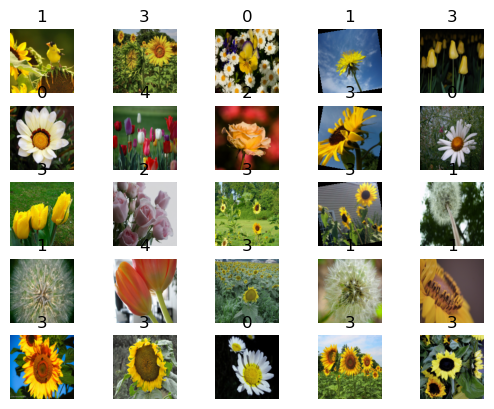

In [ ]:
plot(x_test[:25], prediction[:25])
# 테스트 이미지 중 앞에서 25장(x_test[:25])을 시각화하고,
# 각 이미지 위에 모델의 예측 결과(prediction[:25])를 레이블로 표시함.
# 이때 plot 함수는 미리 정의된 함수로:
#   - 5행 5열로 이미지를 출력
#   - 각 이미지 위에 예측한 정답을 title로 출력
#   - 채널 순서를 (C, H, W) → (H, W, C)로 바꾸기 위해 permute(1,2,0)를 사용

In [ ]:
# 테스트 이미지 폴더에서 데이터를 로드하기 위한 데이터셋 객체 생성
test_data = ImageFolder(
    root='data/test_image',                 # 테스트 이미지가 저장된 디렉터리 경로
    transform=transforms.Compose([         # 이미지 전처리 파이프라인 정의
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # 모든 이미지를 지정된 크기(예: 128x128)로 리사이즈
        transforms.ToTensor()                         # 이미지를 텐서로 변환 (0~255 → 0~1로 정규화)
    ])
)

In [ ]:
# 테스트용 데이터셋을 배치 단위로 불러오는 DataLoader 생성
test_load = DataLoader(
    test_data,       # 앞에서 정의한 ImageFolder 기반의 test_data
    batch_size=10,   # 한 번에 불러올 이미지 수 (배치 크기)
    shuffle=False,   # 테스트 데이터는 순서를 유지 (섞지 않음)
    num_workers=1    # 데이터를 로드할 워커 프로세스 수 (1개 프로세스로 로드)
)

In [ ]:
# test_load에서 첫 번째 배치를 가져옴
# - test_img: 배치에 포함된 이미지들 (텐서)
# - labels: 이미지에 해당하는 정답 레이블

test_img, labels = next(iter(test_load))  # next: DataLoader는 반복자(iterator)이므로 next()로 하나 꺼냄

# 가져온 이미지와 레이블의 텐서 크기 출력
print(test_img.size(), labels.size())

torch.Size([10, 3, 128, 128]) torch.Size([10])


In [ ]:
# 테스트 이미지를 GPU 또는 CPU 장치로 이동
# 모델에 이미지를 넣어 예측값(로짓)을 계산
# → 출력 크기: (배치 크기, 클래스 수)

pred2 = model2(test_img.to(device)).argmax(dim=-1)

# 가장 높은 값을 가진 클래스의 인덱스를 선택 (argmax)
# dim=-1 은 마지막 차원 (클래스 차원)에서 최대값 인덱스를 고름

print(pred2)  # 예측된 클래스 번호들 출력

tensor([2, 2, 3, 1, 4, 0, 3, 3, 4, 4])


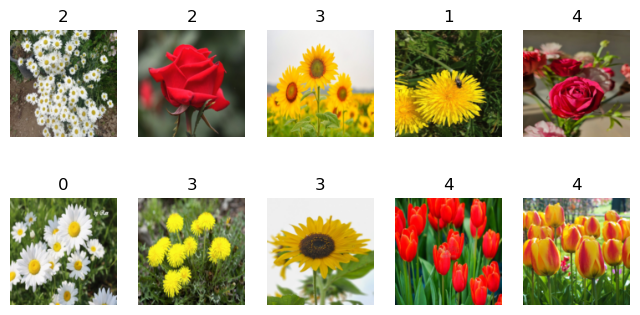

In [ ]:
def plot2(x, y):
    plt.figure(figsize=(8, 4))  # 전체 그래프 크기 설정 (가로 8인치, 세로 4인치)

    for i in range(len(y)):  # y는 예측된 라벨 리스트
        plt.subplot(2, 5, i + 1)  # 2행 5열 중 (i+1)번째 subplot을 선택
        plt.imshow(x[i].permute(1, 2, 0))  # 이미지 텐서의 차원 순서를 (C, H, W) → (H, W, C)로 변환해 시각화
        plt.title(y[i].item())  # 타이틀에 예측된 클래스 번호 표시
        plt.axis('off')  # 축선 숨김

    plt.show()  # 이미지 출력

# 위에서 정의한 plot2 함수를 이용해 테스트 이미지 10장과 예측 결과를 시각화
plot2(test_img, pred2)